# DAPA Tutorial #3: Timeseries - Sentinel-2

## Load environment variables
Please make sure that the environment variable "DAPA_URL" is set in the `custom.env` file. You can check this by executing the following block. 

If DAPA_URL is not set, please create a text file named `custom.env` in your home directory with the following input: 
>DAPA_URL=YOUR-PERSONAL-DAPA-APP-URL

In [3]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `SH_CLIENT_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`, `SH_INSTANCE_ID`

The following additional environment variables have been loaded from `~/custom.env`:
* `DAPA_URL`


## Check notebook compabtibility
**Please note:** If you conduct this notebook again at a later time, the base image of this Jupyter Hub service can include newer versions of the libraries installed. Thus, the notebook execution can fail. This compatibility check is only necessary when something is broken. 

In [4]:
from edc import check_compatibility
check_compatibility("user-0.19.4")

This notebook is compatible with this base image version (user-0.19.4).

## Load libraries
Python libraries used in this tutorial will be loaded.

In [1]:
import os
import xarray as xr
import pandas as pd
import requests
import matplotlib
from ipyleaflet import Map, Rectangle, Marker, DrawControl, basemaps, basemap_to_tiles
%matplotlib inline

## Set DAPA endpoint
Execute the following code to check if the DAPA_URL is available in the environment variable and to set the `/dapa` endpoint. 

In [5]:
service_url = None
dapa_url = None

if 'DAPA_URL' not in os.environ:
    print('!! DAPA_URL does not exist as environment variable. Please make sure this is the case - see first block of this notebook! !!')
else:    
    service_url = os.environ['DAPA_URL']
    dapa_url = '{}/{}'.format(service_url, 'dapa')
    print('DAPA path: {}'.format(dapa_url.replace(service_url, '')))

DAPA path: /dapa


## Get collections supported by this endpoint
This request provides a list of collections. The path of each collection is used as starting path of this service.

In [6]:
print(dapa_url.replace(service_url, ''))
collections = requests.get(dapa_url)
collections.json()

/dapa


['/dapa/DEM/dapa/',
 '/dapa/L8L1C/dapa/',
 '/dapa/S1GRD/dapa/',
 '/dapa/S2L1C/dapa/',
 '/dapa/S2L2A/dapa/',
 '/dapa/S3OLCI/dapa/',
 '/dapa/S3SLSTR/dapa/',
 '/dapa/S5PL2/dapa/',
 '/dapa/MODIS/dapa/']

## Get fields of collection Sentinel-2 L2A
The fields (or variables in other DAPA endpoints - these are the bands of the raster data) can be retrieved in all requests to the DAPA endpoint. In addition to the fixed set of fields, "virtual" fields can be used to conduct math operations (e.g., the calculation of indices). 

In [7]:
collection = 'S2L2A'

fields_url = '{}/{}/{}'.format(dapa_url, collection, 'dapa/fields')
fields = requests.get(fields_url)

print('DAPA path: {}'.format(fields.url.replace(service_url, '')))
fields.json()

DAPA path: /dapa/S2L2A/dapa/fields


[{'id': 'B01'},
 {'id': 'B02'},
 {'id': 'B03'},
 {'id': 'B04'},
 {'id': 'B05'},
 {'id': 'B06'},
 {'id': 'B07'},
 {'id': 'B08'},
 {'id': 'B8A'},
 {'id': 'B09'},
 {'id': 'B11'},
 {'id': 'B12'},
 {'id': 'SCL'},
 {'id': 'SNW'},
 {'id': 'CLD'}]

## Retrieve NDVI as 1d time-series extraced for a single point

### Set DAPA URL and parameters
The output of this request is a time-series requested from a point of interest (`timeseries/position` endpoint). As the input collection (S2L2A) is a multi-temporal raster and the requested geometry is a point, no aggregation is conducted.

To retrieve a time-series of a point, the parameter `point` needs to be provided. The `time` parameter allows to extract data only within a specific time span. The band (`field`) from which the point is being extracted needs to be specified as well.

In [20]:
# DAPA URL
url = '{}/{}/{}'.format(dapa_url, collection, 'dapa/timeseries/position')

# Parameters for this request
params = {
    'point': '11.49,48.05',
    'time': '2018-04-01T00:00:00Z/2018-07-01T00:00:00Z',
    'fields': 'NDVI=(B08-B04)/(B08%2BB04)'    # Please note: + signs need to be URL encoded -> %2B
}

# show point in the map
location = list(reversed([float(coord) for coord in params['point'].split(',')]))
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=location,
    zoom=10
)

marker = Marker(location=location, draggable=False)
m.add_layer(marker)

m

Map(center=[48.05, 11.49], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

### Build request URL and conduct request

In [13]:
params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))

DAPA path: /dapa/S2L2A/dapa/timeseries/position?point=11.49,48.05&time=2018-04-01T00:00:00Z/2018-07-01T00:00:00Z&fields=NDVI=(B08-B04)/(B08%2BB04)
Status code: 200


### Write timeseries dataset to CSV file
The response of this request returns data as CSV including headers splitted by comma. Additional output formats (e.g., CSV with headers included) will be integrated within the testbed activtiy. 

You can either write the response to file or use it as string (`r.content` variable). 

In [16]:
# write time-series data to CSV file
with open('timeseries_s2.csv', 'wb') as filew:
    filew.write(r.content)

### Open timeseries dataset with pandas
Time-series data can be opened, processed, and plotted easily with the `Pandas` library. You only need to specify the `datetime` column to automatically convert dates from string to a datetime object. 

**Please note:** Currently, the order of the entries is in datetime descending. Thus, the data need to be reversed. This will be changed to datetime ascending in the next update of the API. 

In [17]:
# read data into Pandas dataframe
ds = pd.read_csv('timeseries_s2.csv', parse_dates=['datetime'])

# set index to datetime column
ds.set_index('datetime', inplace=True)

# Bug: data need to be reversed to have them in the datetime ascending order
ds = ds.iloc[::-1]

# show dataframe
ds

,NDVI
datetime,
2018-04-02 10:24:35+00:00,0.701217
2018-04-04 10:10:21+00:00,0.229457
2018-04-07 10:20:20+00:00,0.833333
2018-04-09 10:13:43+00:00,0.634615
2018-04-12 10:20:24+00:00,0.100667
2018-04-14 10:15:36+00:00,0.509171
2018-04-17 10:20:21+00:00,0.497207
2018-04-19 10:14:57+00:00,0.686788
2018-04-22 10:21:15+00:00,0.671642


### Plot NDVI data

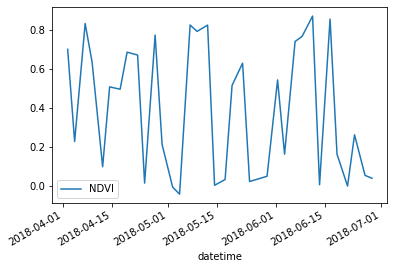

In [18]:
ds.plot()

### Output CSV file

In [19]:
!cat timeseries_s2.csv

datetime,NDVI
2018-06-28T10:13:58Z,0.041703496
2018-06-26T10:26:26Z,0.05631659
2018-06-23T10:11:39Z,0.26386967
2018-06-21T10:23:16Z,0.0018181818
2018-06-18T10:10:24Z,0.16455331
2018-06-16T10:20:21Z,0.8562044
2018-06-13T10:14:24Z,0.008594095
2018-06-11T10:26:34Z,0.8713367
2018-06-08T10:17:26Z,0.7669826
2018-06-08T10:10:24Z,0.7669826
2018-06-06T10:25:12Z,0.74133146
2018-06-03T10:13:29Z,0.16475904
2018-06-01T10:20:24Z,0.5446339
2018-05-29T10:12:25Z,0.051828418
2018-05-24T10:10:22Z,0.024907622
2018-05-22T10:20:25Z,0.6304539
2018-05-19T10:12:07Z,0.5166034
2018-05-17T10:22:09Z,0.03502159
2018-05-14T10:10:52Z,0.005810641
2018-05-12T10:21:48Z,0.82525754
2018-05-09T10:16:21Z,0.79284495
2018-05-07T10:26:48Z,0.8255761
2018-05-04T10:10:23Z,-0.039432675
2018-05-02T10:24:34Z,-0.0036520385
2018-04-29T10:12:58Z,0.2144858
2018-04-27T10:20:22Z,0.77434456
2018-04-24T10:15:26Z,0.0168028
2018-04-22T10:21:15Z,0.67164177
2018-04-19T10:14:57Z,0.68678766
2018-04-17T10:20:21Z,0.49720672
2018-04-14T10:15:36Z,0.5